# WellModel (many wells with one response function)

This notebook shows how a WellModel can be used to fit multiple wells with one response function. The influence of the individual wells is scaled by the distance to the observation point. 

**Authors**
- _R.A. Collenteur, Artesia Water 2018_
- _D.A. Brakenhoff, Artesia Water 2019_

Import the requisite modules

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
from pastas.stressmodels import WellModel

## Load data from Menyanthes file

In [3]:
fname = '../data/MenyanthesTest.men'
meny = ps.read.MenyData(fname)

Get the heads

In [4]:
H = meny.H['Obsevation well']

## Create a model

Create a model with the heads timeseries and add recharge as a stress

In [5]:
ml = ps.Model(ps.TimeSeries(H['values'], name="heads"))

INFO: Cannot determine frequency of series heads


Get the precipitation and evaporation timeseries and round the index to remove the hours from the timestamps.

In [6]:
IN = meny.IN['Precipitation']['values']
IN.index = IN.index.round("D")
IN2 = meny.IN['Evaporation']['values']
IN2.index = IN2.index.round("D")

Create a recharge stressmodel and add to the model

In [7]:
sm = ps.StressModel2([IN, IN2], ps.Gamma, 'Recharge')
ml.add_stressmodel(sm)

INFO: Inferred frequency from time series None: freq=D 
INFO: Inferred frequency from time series None: freq=D 


Get the extraction timeseries and add name to the series.

In [8]:
stresses = [ps.TimeSeries(meny.IN['Extraction 1']["values"], name="Extraction 1"),
            ps.TimeSeries(meny.IN['Extraction 2']["values"], name="Extraction 2"),
            ps.TimeSeries(meny.IN['Extraction 3']["values"], name="Extraction 3")]

INFO: Cannot determine frequency of series Extraction 1
INFO: Cannot determine frequency of series Extraction 2
INFO: Cannot determine frequency of series Extraction 3


Get the distances of the extractions to the observation well

In [9]:
# Get distances from metadata
xo = meny.H["Obsevation well"]['xcoord']
yo = meny.H["Obsevation well"]['ycoord']
distances = []
for extr in ['Extraction 1', 'Extraction 2', 'Extraction 3']:
    xw = meny.IN[extr]["xcoord"]
    yw = meny.IN[extr]["ycoord"]
    distances.append(np.sqrt((xo-xw)**2 + (yo-yw)**2))
distances

[5076.464352236378, 2281.964489666468, 2783.783396746234]

Now we have all the information we need to create a WellModel:
- timeseries for each of the extractions, these are passed as a list of stresses
- distances from each extraction to the observation point, note that the order of these distances must correspond to the order of the stresses.

Note: the WellModel only works with the Hantush response function. This is because the response function must support scaling by a distance $r$. The Hantush response function has been modified to support this. The Hantush response normally takes three parameters: the gain $A$, $\rho$ and $cS$, where parameter $\rho = \tfrac{r}{\lambda}$. When a fourth parameter is passed to Hantush, it interprets that fourth parameter as the distance $r$, and uses it to scale the $A$ and $\rho$ parameters accordingly. 

Create the WellModel and add to the model

In [10]:
w = WellModel(stresses, ps.HantushWellModel, "Wells", distances, settings="well")
ml.add_stressmodel(w)

INFO: Time Series Extraction 2 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 3 was sampled down to freq D with method timestep_weighted_resample
INFO: Time Series Extraction 1 was sampled down to freq D with method timestep_weighted_resample


Solve the model

In [40]:
ml.solve(method="dogbox")

INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Model Results heads                 Fit Statistics
nfev     34                     EVP          93.53
nobs     2843                   R2            0.93
noise    1                      RMSE          0.23
tmin     1960-04-28 00:00:00    AIC          11.72
tmax     2015-06-29 00:00:00    BIC          65.30
freq     D                      ___               
warmup   3650                   ___               
solver   LeastSquares           ___               

Parameters (9 were optimized)
                 optimal   stderr     initial vary
Recharge_A   1300.440998  ±19.12%  210.498526    1
Recharge_n      0.954091   ±3.38%    1.000000    1
Recharge_a    987.459617  ±29.11%   10.000000    1
Recharge_f     -2.000000  ±13.16%   -1.000000    1
Wells_A        -0.000227  ±58.22%   -0.000086    1
Wells_lab    1436.897321  ±26.96%  100.000000    1
Wells_cS      444.714418  ±31.48%  100.000000    1
constant_d     12.023574   ±4.87%    8.557530    1
noise_alpha    55.923752   ±8.37%    1.000000    1


## Visualize the results
Plot the decomposition to see the individual influence of each of the wells

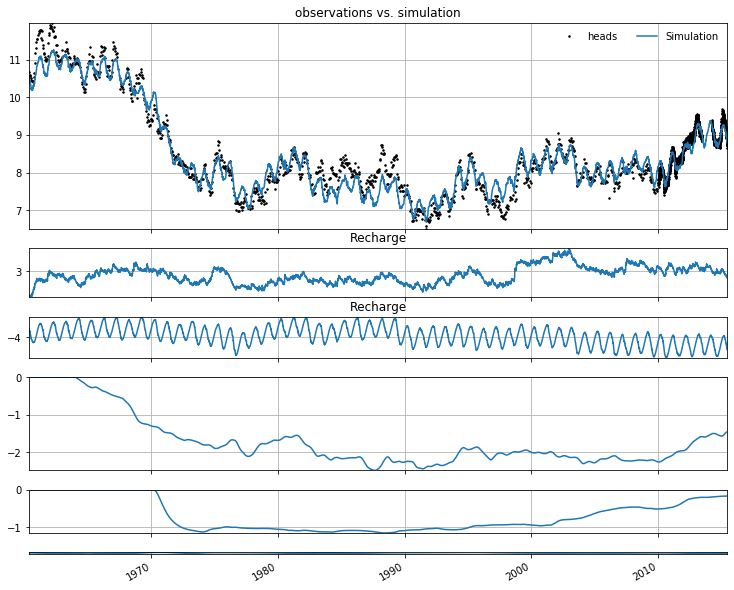

In [41]:
ml.plots.decomposition();

Plot the stacked influence of each of the individual extraction wells in the results plot

In [42]:
#%% Contribution per well on model results plot
def custom_sort(t):
    """Sort by mean contribution"""
    return t[1].mean()

Get the contribution for each well and sort by mean

In [43]:
# Get the contributions for each well
contributions = []
wm = ml.stressmodels["Wells"]
for istress in range(len(wm.stress)):
    h = ml.get_contribution("Wells", istress=istress)
    contributions.append((wm.stress[istress].name, h))
contributions.sort(key=custom_sort)

Plot results and add contributions to the bottom axes

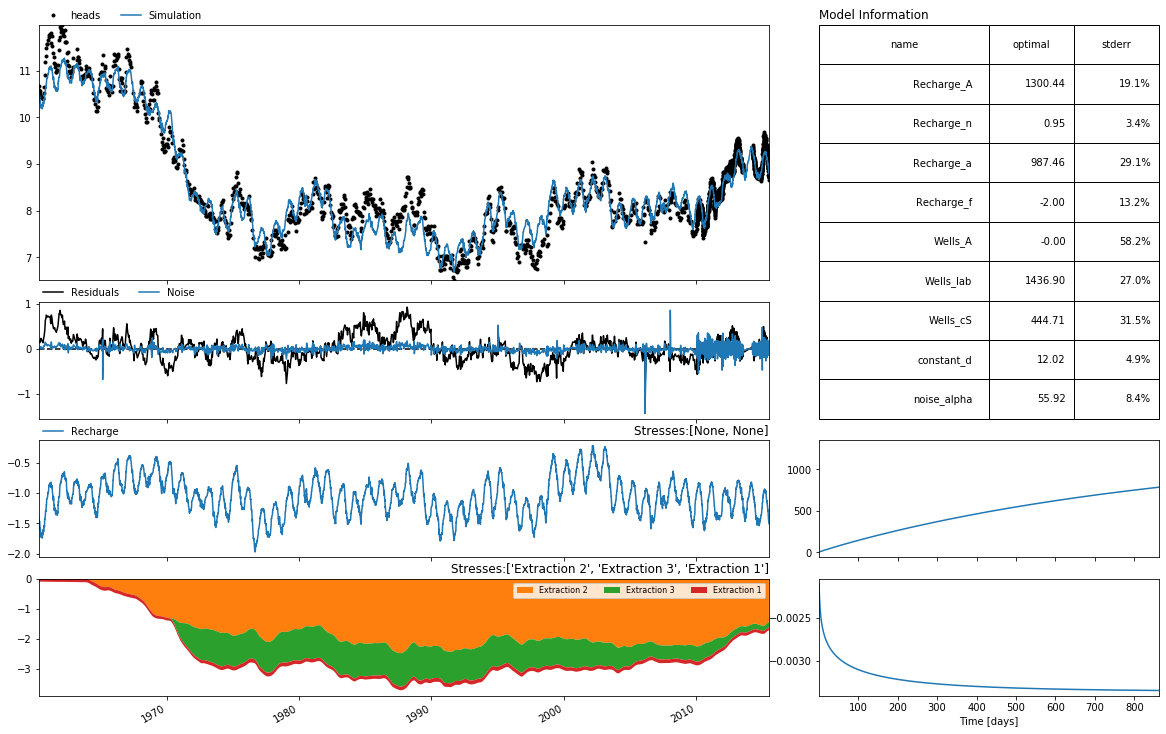

In [44]:
axes = ml.plots.results(figsize=(16, 10))

# add stacked plot to last axes
ax = axes[-2]
del ax.lines[0]  # delete existing line

contrib = [c[1] for c in contributions] # get timeseries
vstack = pd.concat(contrib, axis=1)
names = [c[0] for c in contributions]  # get names
ax.stackplot(vstack.index, vstack.values.T, labels=names)

ax.legend(loc="best", ncol=5, fontsize=8);

Get parameters for each well (including the distance) and calculate the gain:

In [45]:
for i in range(3):
    name = wm.stress[i].name
    p = wm.get_parameters(model=ml, istress=i)
    gain = wm.rfunc.gain(p) * 1e6 / 365
    print("{0}: gain = {1:.2f} m/1e6 m^3/yr".format(name, gain))

Extraction 2: gain = -0.24 m/1e6 m^3/yr
Extraction 3: gain = -0.15 m/1e6 m^3/yr
Extraction 1: gain = -0.02 m/1e6 m^3/yr
